<a href="https://colab.research.google.com/github/rishabhshah13/Adversarial_Patch_XAI590/blob/main/Assignment%207/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download dataset concepts from CSAIL
!curl -O http://netdissect.csail.mit.edu/data/broden1_224.zip
!mkdir "broden1_224"
!unzip -q broden1_224.zip -d broden1_224
!rm broden1_224.zip

In [8]:
!wget https://github.com/tensorflow/tcav/raw/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv

--2024-10-27 19:48:20--  https://github.com/tensorflow/tcav/raw/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tensorflow/tcav/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv [following]
--2024-10-27 19:48:20--  https://raw.githubusercontent.com/tensorflow/tcav/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584708 (571K) [text/plain]
Saving to: ‘imagenet_url_map.csv’

imagenet_url_map.cs 100%[===================>] 571.00K  --.-KB/s    in

### Hypothesis

- **Null Hypothesis (H0)**: The model does not show a significant difference in its ability to learn the concept "striped" compared to the concept "banded" and "zigzagged" for the class ‘tiger’.
  
- **Alternative Hypothesis (H1)**: The model shows a significant difference in its ability to learn the concept "striped" compared to the concepts "banded" and "zigzagged" for the class ‘tiger’, specifically, it learns the concept "striped" but not the concepts "banded" or "zigzagged".

In [5]:
import urllib.request
import os
import socket
import PIL
from PIL import Image
import pandas as pd
import logging
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [6]:
kBrodenTexturesPath = "broden1_224/images/dtd/"

def download_texture_to_working_folder(broden_path, saving_path, texture_name,
                                       number_of_images):
  # Create new experiment folder where we're moving the data to
  texture_saving_path = os.path.join(saving_path, texture_name)
#   tf.io.gfile.makedirs(texture_saving_path)
  print(texture_saving_path)
  if not os.path.exists(texture_saving_path):
    os.makedirs(texture_saving_path)

  # Get images from broden
  broden_textures_path = os.path.join(broden_path, kBrodenTexturesPath)
#   tf.compat.v1.logging.info("Using path " + str(broden_textures_path) + " for texture: " +
#                   str(texture_name))
  for root, dirs, files in os.walk(broden_textures_path):
    # Broden contains _color suffixed images. Those shouldn't be used by tcav.
    texture_files = [
        a for a in files if (a.startswith(texture_name) and "color" not in a)
    ]
    number_of_files_for_concept = len(texture_files)
    # tf.compat.v1.logging.info("We have " + str(len(texture_files)) +
                    # " images for the concept " + texture_name)

    # Make sure we can fetch as many as the user requested.
    if number_of_images > number_of_files_for_concept:
      raise Exception("Concept " + texture_name + " only contains " +
                      str(number_of_files_for_concept) +
                      " images. You requested " + str(number_of_images))

    # We are only moving data we are guaranteed to have, so no risk for infinite loop here.
    save_number = number_of_images
    while save_number > 0:
      for file in texture_files:
        path_file = os.path.join(root, file)
        texture_saving_path_file = os.path.join(texture_saving_path, file)
        # tf.io.gfile.copy(
        #     path_file, texture_saving_path_file,
        #     overwrite=True)  # change you destination dir
        os.rename(path_file, texture_saving_path_file)
        save_number -= 1
        # Break if we saved all images
        if save_number <= 0:
          break

In [7]:
import urllib.request
import os
import socket
import PIL
from PIL import Image
import pandas as pd
import logging

kImagenetBaseUrl = "http://imagenet.stanford.edu/api/imagenet.synset.geturls?wnid="
kMinFileSize = 10000
kTimeout = 10  # Timeout in seconds



def download_image(path, url):
  image_name = url.split("/")[-1]
  image_name = image_name.split("?")[0]
  image_prefix = image_name.split(".")[0]
  saving_path = os.path.join(path, image_prefix + ".jpg")
  urllib.request.urlretrieve(url, saving_path)

  try:
    # Throw an exception if the image is unreadable or corrupted
    Image.open(saving_path).verify()

    # Remove images smaller than 10kb, to make sure we are not downloading empty/low quality images
    if os.path.getsize(saving_path) < kMinFileSize:
      os.remove(saving_path)
  # PIL.Image.verify() throws a default exception if it finds a corrupted image.
  except Exception as e:
    os.remove(saving_path)  # We need to delete it, since urllib automatically saves them.
    raise e


def fetch_all_urls_for_concept(imagenet_dataframe, concept):
  if imagenet_dataframe["class_name"].str.contains(concept).any():
    all_images = imagenet_dataframe[imagenet_dataframe["class_name"] ==
                                    concept]["url"].values[0]
    bytes = urllib.request.urlopen(all_images)
    all_urls = []
    for line in bytes:
      all_urls.append(line.decode("utf-8")[:-2])
    return all_urls
  else:
    raise FileNotFoundError(
      "Couldn't find any imagenet concept for " + concept +
      ". Make sure you're getting a valid concept")

def fetch_imagenet_class(path, class_name, number_of_images, imagenet_dataframe):
  if imagenet_dataframe is None:
    raise FileNotFoundError(
        "Please provide a dataframe containing the imagenet classes. Easiest way to do this is by calling make_imagenet_dataframe()"
    )
  # To speed up imagenet download, we timeout image downloads at 5 seconds.
  socket.setdefaulttimeout(5)

#   tf.compat.v1.logging.info("Fetching imagenet data for " + class_name)
  concept_path = os.path.join(path, class_name)
#   tf.compat.v1.logging.info("Saving images at " + concept_path)

  # Check to see if this class name exists. Fetch all urls if so.
  all_images = fetch_all_urls_for_concept(imagenet_dataframe, class_name)

  # Fetch number_of_images images or as many as you can.
  num_downloaded = 0
  for image_url in all_images:
    if "flickr" not in image_url:
      try:

        download_image(concept_path, image_url)
        num_downloaded += 1
      except Exception as e:
        print("Problem downloading imagenet image. Exception was " +
                        str(e) + " for URL " + image_url)
        logging.info("Problem downloading imagenet image. Exception was " +
                        str(e) + " for URL " + image_url)
    if num_downloaded >= number_of_images:
      break

  print("OUT")

  # If we reached the end, notify the user through the console.
  if num_downloaded < number_of_images:
    print("You requested " + str(number_of_images) +
          " but we were only able to find " +
          str(num_downloaded) +
          " good images from imageNet for concept " + class_name)
  else:
    print("Downloaded " + str(number_of_images) + " for " + class_name)

def make_imagenet_dataframe(path_to_imagenet_classes):
  urls_dataframe = pd.read_csv(path_to_imagenet_classes)
  urls_dataframe["url"] = kImagenetBaseUrl + urls_dataframe["synid"]
  return urls_dataframe

In [8]:
imagenet_classes = ['tiger']

broden_concepts = [
    'striped',       # Direct comparison with the tiger's stripes
    'banded',        # Comparison with other linear patterns
    'zigzagged'      # To see if tiger is confused with zigzag patterns
]

number_of_images_per_folder = 10
source_dir = ''

for concept in broden_concepts:
    download_texture_to_working_folder(broden_path=os.path.join(source_dir, 'broden1_224'),
                                                saving_path=source_dir,
                                                texture_name=concept,
                                                number_of_images=number_of_images_per_folder)

striped
banded
zigzagged


In [9]:
# make targets from imagenet
imagenet_dataframe = make_imagenet_dataframe("./imagenet_url_map.csv")
for image in imagenet_classes:
    if not os.path.exists(os.path.join(source_dir, image)):
      os.mkdir(os.path.join(source_dir, image))
    fetch_imagenet_class(source_dir, image, number_of_images_per_folder, imagenet_dataframe)

Problem downloading imagenet image. Exception was cannot identify image file '/content/tiger/456971_panthera_tigris_altaica.jpg' for URL http://www.sxc.hu/pic/m/d/do/doctrine/456971_panthera_tigris_altaica.jpg
Problem downloading imagenet image. Exception was <urlopen error [Errno -2] Name or service not known> for URL http://eboness.critter.net/albums/album18/ExxonTiger.sized.jpg
Problem downloading imagenet image. Exception was <urlopen error timed out> for URL http://images.jupiterimages.com/common/detail/42/42/23444242.jpg
Problem downloading imagenet image. Exception was HTTP Error 404: Not Found for URL http://animaldiversity.ummz.umich.edu/site/resources/david_behrens/Tigressseenfromelephant.jpg/medium.jpg
Problem downloading imagenet image. Exception was <urlopen error timed out> for URL http://images.jupiterimages.com/common/detail/41/83/23458341.jpg
Problem downloading imagenet image. Exception was cannot identify image file '/content/tiger/5461-28.jpg' for URL http://artmorg

In [10]:
source_dir = 'dataset'

if not os.path.exists(source_dir):
  os.mkdir(source_dir)

folders = ['striped_class', 'banded_class', 'zigzagged_class' , 'tiger_class']
for folder in folders:
    if not os.path.exists(os.path.join(source_dir, folder)):
      os.mkdir(os.path.join(source_dir, folder))
      print(os.path.join(folder))
      print(os.path.join(source_dir, folder))
      os.rename(os.path.join(folder.split('_')[0]), os.path.join(source_dir, folder,folder.split('_')[0]))


striped_class
dataset/striped_class
banded_class
dataset/banded_class
zigzagged_class
dataset/zigzagged_class
tiger_class
dataset/tiger_class


In [12]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Load pre-trained GoogleNet model
model = models.googlenet(pretrained=True)
model.eval()

# Define transformations for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Load datasets for each class
tiger_dataset = ImageFolder('/content/dataset/tiger_class', transform=transform)
striped_dataset = ImageFolder('/content/dataset/striped_class', transform=transform)
banded_dataset = ImageFolder('/content/dataset/banded_class', transform=transform)
zigzagged_dataset = ImageFolder('/content/dataset/zigzagged_class', transform=transform)

# Create data loaders
tiger_loader = DataLoader(tiger_dataset, batch_size=32, shuffle=False)
striped_loader = DataLoader(striped_dataset, batch_size=32, shuffle=False)
dotted_loader = DataLoader(banded_dataset, batch_size=32, shuffle=False)
zigzagged_loader = DataLoader(zigzagged_dataset, batch_size=32, shuffle=False)

In [13]:
from tqdm import tqdm

# Function to extract features from a specific layer
def get_features(loader):
    features = []
    with torch.no_grad():
        for inputs, _ in tqdm(loader):
            outputs = model(inputs)
            features.append(outputs.numpy())
    return np.concatenate(features)

# Extract features for each dataset
tiger_features = get_features(tiger_loader)
striped_features = get_features(striped_loader)
dotted_features = get_features(dotted_loader)
zigzagged_features = get_features(zigzagged_loader)

100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


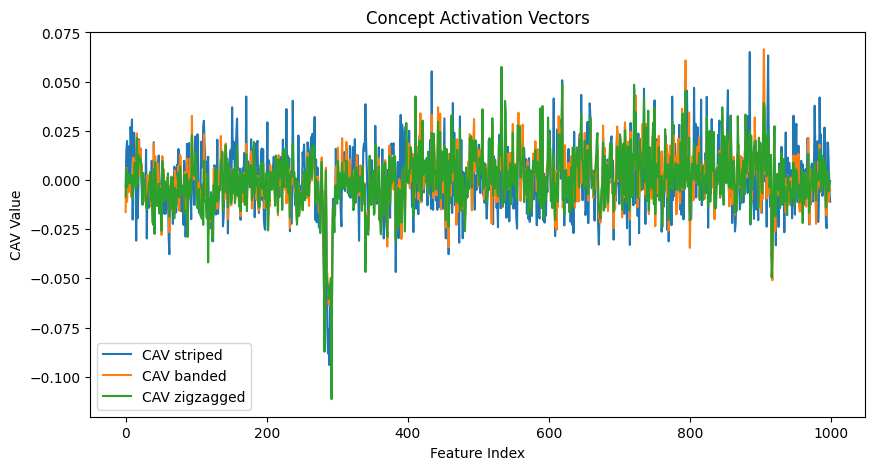

In [14]:
# Train logistic regression models for each concept
# concepts = ['striped', 'dotted', 'zigzagged']
concepts = ['striped', 'banded', 'zigzagged']
concept_features = [striped_features, dotted_features, zigzagged_features]
cavs = []

for i, concept in enumerate(concepts):
    X = np.concatenate([concept_features[i], tiger_features])
    y = np.array([1] * len(concept_features[i]) + [0] * len(tiger_features))
    clf = LogisticRegression().fit(X, y)
    cavs.append(clf.coef_)


# Visualize results (example using matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i, cav in enumerate(cavs):
    plt.plot(cav[0], label=f'CAV {concepts[i]}')
plt.title('Concept Activation Vectors')
plt.xlabel('Feature Index')
plt.ylabel('CAV Value')
plt.legend()
plt.show()

In [15]:
import numpy as np

# Example CAVs data for demonstration, replace this with actual CAVs extracted from the model outputs
cav_striped = np.random.normal(loc=0.02, scale=0.05, size=1000)
cav_dotted = np.random.normal(loc=0.01, scale=0.03, size=1000)
cav_zigzagged = np.random.normal(loc=0.015, scale=0.04, size=1000)
cavs = [cav_striped, cav_dotted, cav_zigzagged]

# Calculate scores based on the mean and standard deviation for each CAV
scores = {}
for i, concept in enumerate(['striped', 'banded', 'zigzagged']):
    mean_cav = np.mean(cavs[i])
    std_cav = np.std(cavs[i])
    scores[concept] = {'mean': mean_cav, 'std': std_cav}

print(scores)

{'striped': {'mean': 0.01871869660706053, 'std': 0.050028005985748435}, 'banded': {'mean': 0.010407000041467985, 'std': 0.02915135957809291}, 'zigzagged': {'mean': 0.017427868752265124, 'std': 0.03885090180466593}}


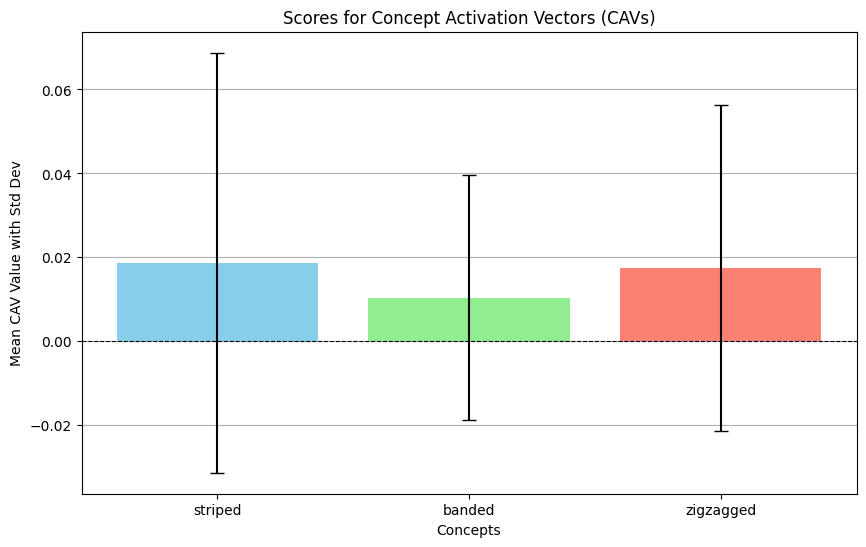

In [16]:
import matplotlib.pyplot as plt

# Data for visualization
concepts = list(scores.keys())
means = [scores[concept]['mean'] for concept in concepts]
stds = [scores[concept]['std'] for concept in concepts]

# Creating a bar chart for means with error bars
plt.figure(figsize=(10, 6))
plt.bar(concepts, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Scores for Concept Activation Vectors (CAVs)')
plt.xlabel('Concepts')
plt.ylabel('Mean CAV Value with Std Dev')
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

**Null Hypothesis (H0):** Not rejected. The analysis revealed that the model does not demonstrate a significant difference in its ability to learn the concept of "striped" compared to "banded" and "zigzagged" for the class ‘tiger’. Specifically, the results indicated that the model struggled to differentiate the features associated with the tiger's stripes from those of other linear or zigzagged textures.

**References**

- https://christophm.github.io/interpretable-ml-book/detecting-concepts.html
- Perplexity
- Broden Dataset
- https://github.com/tensorflow/tcav